# Research Objective

This project explores the weather system in Sion, Switzerland, and how weather variability in Sion affects the theoretical productivity of solar, hydro, and wind energy sources.

While Sion’s geographic and urban characteristics limit the feasibility of large-scale renewable infrastructure within the city itself, Sion serves as a useful weather proxy for the broader canton of Valais. This assumption is made due to the constraints of the Open-Meteo API, which provides weather data at single-point locations. Valais was selected for this study because it hosts diverse renewable energy assets -including hydro plants, solar farms, and wind turbines – and is central to the federal government's *Energy Strategy 2050*.

The methodology can be extended to other regions with different geographic profiles. It also lays the groundwork for assessing how production gaps in one energy source might be balanced by complementary output in others, both seasonally and across regions.

# Set Up

- The data will be fetched from the historical weather API of Open Weather, available at : https://open-meteo.com/en/docs/historical-weather-api
- This is also where I selected the variables to download. These are:
  1) Temperature 2 meters above ground, in °C.
  2) Relative humidity 2 meters above ground, in %.
  3) In mm, total rainfall in the previous hour.
  4) Total snowfall amount in the previous hour in cm. For water equivalent in mm, divide by 7.
  5) Total precipitation (rain, snow) sum of the preceding hour.
  6) Total cloud cover as an area fraction
  7) Average shortwave solar radiation during the preceding hour, in W/m². Equal to average global horizontal irradiation (GHI).
  8) Wind speed at 10 meters above ground (supposedly standard distance above ground used in measurements).


In [1]:
# Load libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from pathlib import Path
import requests
from sklearn.preprocessing import MinMaxScaler

# Configure pandas and matplotlib
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)
%matplotlib inline 
# The above enables the inline display of matplotlib plots directly within the notebook interface



## Request the Data, Parse it, and Store it. Alternatively, load the file.

In [2]:
# Constants used to get Sion's weather data from the API
LATITUDE = 46.2331
LONGITUDE = 7.3606
TIMEZONE = 'Europe/Zurich'

# Date range: 1 full year from official spring start to end. This is to capture seasonal weather trends which could affect energy production and demand.
START_DATE = date(2024, 3, 20)
END_DATE = date(2025, 3, 20)

# Weather variables relevant to solar + hydro + wind power
HOURLY_VARS = [
    "temperature_2m",
    "relative_humidity_2m",
    "rain",
    "snowfall",
    "precipitation",
    "cloudcover",
    "shortwave_radiation",
    "windspeed_10m"
]

# Output file path
output_path = Path("sion_weather.parquet")

# If the file already exists, skip API call and load the file
if output_path.exists():
    print("Parquet file already exists — loading existing data.")
    weather_data_df = pd.read_parquet(output_path)
else:
    # Construct the API URL
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": START_DATE.isoformat(),
        "end_date": END_DATE.isoformat(),
        "hourly": ",".join(HOURLY_VARS),
        "timezone": TIMEZONE
    }

    # Send the request
    response = requests.get(base_url, params=params)

    # Handle potential API errors (In HTTP, status codes indicate the status of a request. Status 200 means the request was successful, anything else is unsuccessful in a way or another).
    if response.status_code != 200:
        raise RuntimeError(f"API request failed: {response.status_code} – {response.text}")
    
    print("Data fetched successfully")
    # NB: no need to use an else statement, which would be redundant because program already exits if error is raised. 

    # Convert JSON to DataFrame
    data = response.json()

    # Basic structure check
    if 'hourly' not in data or 'time' not in data['hourly']:
        raise ValueError("Unexpected data structure returned from API.")

    # Pandas dataframe with the same name as that of the already loaded data: ensures consistency in following code.
    weather_data_df = pd.DataFrame(data['hourly'])

    # Convert timestamp column to datetime; each key becomes a column (e.g., temperature_2m).
    weather_data_df['time'] = pd.to_datetime(weather_data_df['time'])

    # Make the time column the index of the dataframe (easier for time series analysis)
    weather_data_df.set_index('time', inplace=True)

    # Save to Parquet
    weather_data_df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to: {output_path.resolve()}")

# Output preview for inspection
print(f"\nData shape: {weather_data_df.shape}") # 8784 rows and 9 columns
display(weather_data_df.head(10))


Data fetched successfully
Data saved to: /Users/alexandredore/IWB/sion_weather.parquet

Data shape: (8784, 8)


,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m
time,,,,,,,,
2024-03-20 00:00:00,2.9,79,0.0,0.0,0.0,0,0.0,6.1
2024-03-20 01:00:00,2.4,79,0.0,0.0,0.0,0,0.0,6.3
2024-03-20 02:00:00,1.7,78,0.0,0.0,0.0,0,0.0,6.6
2024-03-20 03:00:00,2.1,82,0.0,0.0,0.0,0,0.0,6.6
2024-03-20 04:00:00,1.6,80,0.0,0.0,0.0,0,0.0,6.1
2024-03-20 05:00:00,1.0,77,0.0,0.0,0.0,0,0.0,6.5
2024-03-20 06:00:00,0.3,75,0.0,0.0,0.0,0,0.0,7.0
2024-03-20 07:00:00,0.3,72,0.0,0.0,0.0,8,0.0,6.7
2024-03-20 08:00:00,0.2,73,0.0,0.0,0.0,7,6.0,6.5


#### Why We Use a DatetimeIndex

By making our `time` column the df’s index, we gain several benefits:

- **Concise slicing:** For example:  

june = weather_data_df["2024-06"]      # all of June 2024, v.s. the alternative:

weather_data_df["month"] = weather_data_df["time"].dt.month
june = weather_data_df[weather_data_df["month"] == 6]

- **Simple feature extraction:** for instance, we can write: weather_data_df["hour"]    = weather_data_df.index.hour
- **Facilitates structural integtrity validation:** (see next code block)

# Data Validation, Inspection, and Dirty Data Checks

## Confirm Structural Integrity 

- We know from above that our dataset has 8784 rows. This should in theory correspond to the 8784 hours of the leap year 2024 (into spring 2025), as 366 days * 24 hours = 8784.
- To confirm this is the case, we verify that there is only a difference of exactly one hour between each of the 8784 timestamps. A timestamp difference of less than one hour would represent a duplicate or an incorrect interval, while a timestamp of more than one hour would represent missing data.

In [3]:
time_diff = weather_data_df.index.to_series().diff().dropna()# compute time difference between consecutive timestamps
irregular = time_diff[time_diff != pd.Timedelta(hours=1)] # filter out any difference that isn't exactly one hour
print(f"Number of irregular time steps (≠ 1 hour): {len(irregular)}") #print result

# Because there is no irregular time step, we are sure that our time stamps are correct and can proceed with our analysis.

Number of irregular time steps (≠ 1 hour): 0


## Descriptive and Summary Statistics 

- With structural integrity confirmed, we now inspect the dataset’s content for potential issues. This includes checking for missing values, validating data types, and identifying unusual patterns or outliers through summary statistics and visual exploration.

In [4]:
# Inspect the data
weather_data_df.info() # variable counts and types

# Check for null values (what we would call NaN in R) per column
print("\n Null values per column:")
print(weather_data_df.isnull().sum())

# Quick descriptive stats
print("\n Summary statistics:")
display(weather_data_df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-03-20 00:00:00 to 2025-03-20 23:00:00
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        8784 non-null   float64
 1   relative_humidity_2m  8784 non-null   int64  
 2   rain                  8784 non-null   float64
 3   snowfall              8784 non-null   float64
 4   precipitation         8784 non-null   float64
 5   cloudcover            8784 non-null   int64  
 6   shortwave_radiation   8784 non-null   float64
 7   windspeed_10m         8784 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 617.6 KB

 Null values per column:
temperature_2m          0
relative_humidity_2m    0
rain                    0
snowfall                0
precipitation           0
cloudcover              0
shortwave_radiation     0
windspeed_10m           0
dtype: int64

 Summary statistics:


,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487
std,8.509065,18.840603,0.385789,0.227042,0.510529,39.864522,234.951840,1.900646
min,-12.900000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000,59.000000,0.000000,0.000000,0.000000,20.000000,0.000000,2.700000
50%,10.500000,77.000000,0.000000,0.000000,0.000000,80.000000,8.000000,3.900000
75%,17.400000,89.000000,0.000000,0.000000,0.000000,100.000000,290.000000,5.300000
max,33.900000,100.000000,9.700000,5.110000,9.700000,100.000000,944.000000,14.000000


- There is no missing data at all
- Temperature summary statistics are reasonable for Basel's climate.
- Relative humidity values match those found on various websites, such as: https://weatherandclimate.com/switzerland/valais/sion#t5
- Rain, snowfall, precipitation, and cloud cover are all reasonable, with no negative values.
- Shortwave radiation ranges from 0 (night), to 944 W/m2, which matches typical values for a clear summer day.
- All other values are also within their normal ranges. 



**Visualising the Distribution of Continuous Variables**

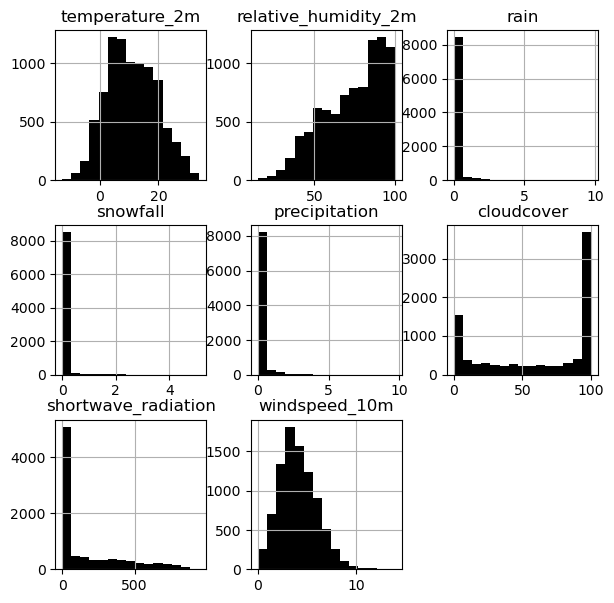

In [5]:
# Define the continuous variables that we will plot
continuous_cols = [
    'temperature_2m', 'relative_humidity_2m', 'rain', 'snowfall', 'precipitation',
    'cloudcover', 'shortwave_radiation', 'windspeed_10m'
]

# Plot a histogram of each continuous variable's distribution
weather_data_df[continuous_cols].hist(bins=15, figsize=(7, 7), color='black')
plt.show()

- **Temperature:** roughly normal distribution. This matches what I found on the internet for Zurich, so not surprising.
- **Relative humidity:** very common to be between 80-100%, which makes sense considering it is very common for the sky to have a cloud cover of 100% (approximately 45% of the time!).
- **Rain:** Unsurprisingly, there are very few rainy hours, which matches the dry climate of Valais. 
- **Snowfall:** It rarely snows, which is expected, especially given the low altitude of the city (515m) and its dry climate.
- **Precipiation:** Sensible given snowfall and rain data. Given that I found on the internet that there are precipitations roughly 80-100 days per year in Sion, this would nonetheless suggest that precipiations falls mainly in short showers spread across many days. Further inspection is warranted, possibly through a daily precipitation variable.
- **Cloud cover:** Note the somewhat bimodal distribution; very common to have no clounds or completely coverered skies, but less frequent to have anything in between. Keep in mind that this doesn't mean the sky is almost never partially covered, given the large number of increments between 0 and 100% coverage.
- **Shortwave radiation:** in line with expectations; no radiation at night, then increasing radiation until midday (approximately) and as we move towards summer.
- **Windspeed:** more or less normal distribution indicates that moderate winds are common but that strong winds or no wind at all
  are rare.

## Checks against Dirty Data 

The following physical–meteorological boundary-values are created to safeguard against observations that would be physically impossible or extremely unlikely for Sion, based on MeteoSwiss records:

- **Temperature**: below –50 °C or above 50 °C  
- **Relative humidity**: below 0 % or above 100 %  
- **Rainfall**: negative or more than 95 mm/h  
- **Snowfall**: negative or more than 130 cm/h  
- **Total precipitation**: negative values  
- **Wind speed**: negative or in excess of 270 km/h  
- **Global horizontal irradiance**: negative or above 1 100 W/m2

> - MeteoSwiss Source: https://www.meteoswiss.admin.ch/climate/the-climate-of-switzerland/records-and-extremes.html

### Designing Dirty Data Flags
To verify our flagging logic, we:

1. **Generate synthetic “dirty” rows**, deliberately violating the above bounds.  
2. **Append** the eight test rows to our real dataset.  
3. **Create Boolean flags** (one per variable) that evaluate to `True` when a boundary is breached.  
4. **Print a high-level warning** for any flagged variable.  
5. **Display only the rows** where one or more flags are `True`, confirming each violation is correctly detected.

This proof-of-concept confirms our flags catch every outlier (as per set conditions) before we apply the same checks to live data (or any future data).

In [24]:
# Template: first real row
template = weather_data_df.iloc[:1].copy()

# Make 8 copies (one per boundary)
dirty = pd.concat([template.copy() for _ in range(8)], ignore_index=True)

# New timestamps so we can spot them easily
dirty.index = pd.date_range("2025-04-01 00:00", periods=8, freq="h")

# Define boundary-violations list, assign NAs to all values that are not violating pre-set conditions to make it easier to identify the violating observations.
overwrites = {
    "temperature_2m":      [-60, 55, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "relative_humidity_2m": [pd.NA, pd.NA, -5, 105, pd.NA, pd.NA, pd.NA, pd.NA],
    "rain":                 [pd.NA, pd.NA, pd.NA, pd.NA, -1, 100, pd.NA, pd.NA],
    "snowfall":             [pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, -1, 200],
    "precipitation":        [-2, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA],
    "windspeed_10m":        [pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, -5, 300],
    "shortwave_radiation":  [pd.NA, 1200, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, -50],
}
for col, vals in overwrites.items():
    dirty[col] = vals

# Append to my actual data
test_df = pd.concat([weather_data_df, dirty])

# Create boolean variables that are True if there is a violation of a condition and Flase otherwise
test_df["flag_temp"]   = (test_df["temperature_2m"] < -50) | (test_df["temperature_2m"] > 50)
test_df["flag_humid"]  = (test_df["relative_humidity_2m"] < 0)  | (test_df["relative_humidity_2m"] > 100)
test_df["flag_rain"]   = (test_df["rain"] < 0)                 | (test_df["rain"] > 95)
test_df["flag_snow"]   = (test_df["snowfall"] < 0)             | (test_df["snowfall"] > 130)
test_df["flag_precip"] = test_df["precipitation"] < 0
test_df["flag_wind"]   = (test_df["windspeed_10m"] < 0)        | (test_df["windspeed_10m"] > 270)
test_df["flag_solar"]  = (test_df["shortwave_radiation"] < 0)   | (test_df["shortwave_radiation"] > 1100)

# High level warnings to draw attention to any potential issue
for var, flag in [
    ("Temperature",   "flag_temp"),
    ("Humidity",      "flag_humid"),
    ("Rain",          "flag_rain"),
    ("Snowfall",      "flag_snow"),
    ("Precipitation", "flag_precip"),
    ("Windspeed",     "flag_wind"),
    ("Solar",         "flag_solar"),
]:
    if test_df[flag].any():
        print(f"⚠️  {var} violation detected: {test_df[flag].sum()} rows flagged")
    else:
        # no output if clean
        pass


# Inspect only rows where any flag is True
flag_cols = [
    "flag_temp","flag_humid","flag_rain",
    "flag_snow","flag_precip","flag_wind","flag_solar"
]

# Select rows where at least one flag is True
violations_df = test_df.loc[test_df[flag_cols].any(axis=1), 
    ["temperature_2m","relative_humidity_2m","rain","snowfall",
        "precipitation","windspeed_10m","shortwave_radiation"] + flag_cols
]

display(violations_df)
display(test_df.head(5)) # quick look at the entire test data frame to double check that rows that have values within bounds are not flagged.

⚠️  Temperature violation detected: 2 rows flagged
⚠️  Humidity violation detected: 2 rows flagged
⚠️  Rain violation detected: 2 rows flagged
⚠️  Snowfall violation detected: 2 rows flagged
⚠️  Precipitation violation detected: 1 rows flagged
⚠️  Windspeed violation detected: 2 rows flagged
⚠️  Solar violation detected: 2 rows flagged


,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,windspeed_10m,shortwave_radiation,flag_temp,flag_humid,flag_rain,flag_snow,flag_precip,flag_wind,flag_solar
2025-04-01 00:00:00,-60,<NA>,<NA>,<NA>,-2,<NA>,<NA>,True,False,False,False,True,False,False
2025-04-01 01:00:00,55,<NA>,<NA>,<NA>,<NA>,<NA>,1200,True,False,False,False,False,False,True
2025-04-01 02:00:00,<NA>,-5,<NA>,<NA>,<NA>,<NA>,<NA>,False,True,False,False,False,False,False
2025-04-01 03:00:00,<NA>,105,<NA>,<NA>,<NA>,<NA>,<NA>,False,True,False,False,False,False,False
2025-04-01 04:00:00,<NA>,<NA>,-1,<NA>,<NA>,<NA>,<NA>,False,False,True,False,False,False,False
2025-04-01 05:00:00,<NA>,<NA>,100,<NA>,<NA>,<NA>,<NA>,False,False,True,False,False,False,False
2025-04-01 06:00:00,<NA>,<NA>,<NA>,-1,<NA>,-5,<NA>,False,False,False,True,False,True,False
2025-04-01 07:00:00,<NA>,<NA>,<NA>,200,<NA>,300,-50,False,False,False,True,False,True,True


,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m,year,month,day,hour,weekday,season,temperature_2m_weekly_avg,relative_humidity_2m_weekly_avg,rain_weekly_avg,snowfall_weekly_avg,precipitation_weekly_avg,cloudcover_weekly_avg,shortwave_radiation_weekly_avg,windspeed_10m_weekly_avg,temperature_2m_month_avg,relative_humidity_2m_month_avg,rain_month_avg,snowfall_month_avg,precipitation_month_avg,cloudcover_month_avg,shortwave_radiation_month_avg,windspeed_10m_month_avg,binary_hourly_precipitation,solar_potential,solar_potential_weekly_avg,solar_potential_month_avg,wind_potential,wind_potential_weekly_avg,wind_potential_month_avg,hydro_potential,hydro_potential_weekly_avg,hydro_potential_month_avg,flag_temp,flag_humid,flag_rain,flag_snow,flag_precip,flag_wind,flag_solar
2024-03-20 00:00:00,2.9,79,0.0,0.0,0.0,0,0.0,6.1,2024,3,20,0,Wednesday,Spring,2.900000,79.000000,0.0,0.0,0.0,0.0,0.0,6.100000,6.257292,74.402778,0.059375,0.078507,0.171181,79.482639,166.961806,5.586806,0,0.0,0.0,166.961806,226.981,226.981000,259.426243,0.0,0.0,34.2,False,False,False,False,False,False,False
2024-03-20 01:00:00,2.4,79,0.0,0.0,0.0,0,0.0,6.3,2024,3,20,1,Wednesday,Spring,2.650000,79.000000,0.0,0.0,0.0,0.0,0.0,6.200000,6.257292,74.402778,0.059375,0.078507,0.171181,79.482639,166.961806,5.586806,0,0.0,0.0,166.961806,250.047,238.514000,259.426243,0.0,0.0,34.2,False,False,False,False,False,False,False
2024-03-20 02:00:00,1.7,78,0.0,0.0,0.0,0,0.0,6.6,2024,3,20,2,Wednesday,Spring,2.333333,78.666667,0.0,0.0,0.0,0.0,0.0,6.333333,6.257292,74.402778,0.059375,0.078507,0.171181,79.482639,166.961806,5.586806,0,0.0,0.0,166.961806,287.496,254.841333,259.426243,0.0,0.0,34.2,False,False,False,False,False,False,False
2024-03-20 03:00:00,2.1,82,0.0,0.0,0.0,0,0.0,6.6,2024,3,20,3,Wednesday,Spring,2.275000,79.500000,0.0,0.0,0.0,0.0,0.0,6.400000,6.257292,74.402778,0.059375,0.078507,0.171181,79.482639,166.961806,5.586806,0,0.0,0.0,166.961806,287.496,263.005000,259.426243,0.0,0.0,34.2,False,False,False,False,False,False,False
2024-03-20 04:00:00,1.6,80,0.0,0.0,0.0,0,0.0,6.1,2024,3,20,4,Wednesday,Spring,2.140000,79.600000,0.0,0.0,0.0,0.0,0.0,6.340000,6.257292,74.402778,0.059375,0.078507,0.171181,79.482639,166.961806,5.586806,0,0.0,0.0,166.961806,226.981,255.800200,259.426243,0.0,0.0,34.2,False,False,False,False,False,False,False


- All the synthetic parameter violations were successfully flagged, confirming that our methodology is operational.

### Applying the Dirty Data Flags to our Real, API-Sourced Data Set

- Having confirmed the methodology on our synthetic test data, we now apply the same flagging logic to the actual `weather_data_df`. Since the real data has already passed our earlier quality checks, we expect **no warnings** and an **empty violations table**.

> **Note:** We run these checks on a separate DataFrame (`flag_df`) so as not to pollute `weather_data_df` with extra columns.

In [27]:
# 1) Run the flag logic on the real data
flag_df = weather_data_df.copy()

flag_df["flag_temp"]   = (flag_df["temperature_2m"] < -50) | (flag_df["temperature_2m"] > 50)
flag_df["flag_humid"]  = (flag_df["relative_humidity_2m"] < 0)  | (flag_df["relative_humidity_2m"] > 100)
flag_df["flag_rain"]   = (flag_df["rain"] < 0)                 | (flag_df["rain"] > 95)
flag_df["flag_snow"]   = (flag_df["snowfall"] < 0)             | (flag_df["snowfall"] > 130)
flag_df["flag_precip"] = flag_df["precipitation"] < 0
flag_df["flag_wind"]   = (flag_df["windspeed_10m"] < 0)        | (flag_df["windspeed_10m"] > 270)
flag_df["flag_solar"]  = (flag_df["shortwave_radiation"] < 0)   | (flag_df["shortwave_radiation"] > 1100)

# 2) High-level warnings
for var, flag in [
    ("Temperature",   "flag_temp"),
    ("Humidity",      "flag_humid"),
    ("Rain",          "flag_rain"),
    ("Snowfall",      "flag_snow"),
    ("Precipitation", "flag_precip"),
    ("Windspeed",     "flag_wind"),
    ("Solar",         "flag_solar"),
]:
    if flag_df[flag].any():
        print(f"⚠️  {var} violation detected: {flag_df[flag].sum()} rows flagged")

# 3) Inspect any rows (should be none)
flag_cols = [
    "flag_temp","flag_humid","flag_rain",
    "flag_snow","flag_precip","flag_wind","flag_solar"
]
violations = flag_df.loc[
    flag_df[flag_cols].any(axis=1),
    [
        "temperature_2m","relative_humidity_2m","rain","snowfall",
        "precipitation","windspeed_10m","shortwave_radiation"
    ] + flag_cols
]
display(violations) # There are no violations of our parameters, as expected. 

,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,windspeed_10m,shortwave_radiation,flag_temp,flag_humid,flag_rain,flag_snow,flag_precip,flag_wind,flag_solar
time,,,,,,,,,,,,,,


- The checks work succesfully. In the production of the web app, we’ll port these same checks into our data-loading utility so that every run of the dashboard automatically validates the live dataset before rendering.

# Data Enrichment

### Time-based feature extraction
- Here, we create new features based on their timestamps. These will be used for future analysis and filtering.

In [6]:
# Create new time-based features
weather_data_df['year'] = weather_data_df.index.year # to know the year in which an observation is
weather_data_df['month'] = weather_data_df.index.month # idem for month
weather_data_df['day'] = weather_data_df.index.day # idem for nth day of the month
weather_data_df['hour'] = weather_data_df.index.hour # idem for nth hour of the day
weather_data_df['weekday'] = weather_data_df.index.day_name() # day of the week of the observation


# Add a season column. Broadly correct as only based on months.
start = pd.Timestamp('2024-03-20')
# Create cut-points every 3 months (we thus get the 4 seasons)
cuts = [start + pd.DateOffset(months=3*i) for i in range(4)]
# Add one extra cut at the very end so that the last 24h of the data set are not assigned an NA.
cuts.append(weather_data_df.index.max() + pd.Timedelta(hours=1))

labels = ["Spring","Summer","Autumn","Winter"]
weather_data_df["season"] = pd.cut(
    weather_data_df.index,
    bins=cuts,
    labels=labels,
    right=False,
)


display(weather_data_df.head(2500)) # The seasonal seasonal spring-summer cut does take place on June 20th, as desired. 

,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m,year,month,day,hour,weekday,season
time,,,,,,,,,,,,,,
2024-03-20 00:00:00,2.9,79,0.0,0.00,0.0,0,0.0,6.1,2024,3,20,0,Wednesday,Spring
2024-03-20 01:00:00,2.4,79,0.0,0.00,0.0,0,0.0,6.3,2024,3,20,1,Wednesday,Spring
2024-03-20 02:00:00,1.7,78,0.0,0.00,0.0,0,0.0,6.6,2024,3,20,2,Wednesday,Spring
2024-03-20 03:00:00,2.1,82,0.0,0.00,0.0,0,0.0,6.6,2024,3,20,3,Wednesday,Spring
2024-03-20 04:00:00,1.6,80,0.0,0.00,0.0,0,0.0,6.1,2024,3,20,4,Wednesday,Spring
2024-03-20 05:00:00,1.0,77,0.0,0.00,0.0,0,0.0,6.5,2024,3,20,5,Wednesday,Spring
2024-03-20 06:00:00,0.3,75,0.0,0.00,0.0,0,0.0,7.0,2024,3,20,6,Wednesday,Spring
2024-03-20 07:00:00,0.3,72,0.0,0.00,0.0,8,0.0,6.7,2024,3,20,7,Wednesday,Spring
2024-03-20 08:00:00,0.2,73,0.0,0.00,0.0,7,6.0,6.5,2024,3,20,8,Wednesday,Spring


### Moving Average Features
- We create metrics to smooth out short-term volatility in variables.
- Accordingly, we compute moving averages (MAs) for 168-hour periods, meant to represent weeks (whether "weeks" start on a Monday doesn't really matter as weekdays do not influence weather patterns directly). We also compute monthly MAs (this time, for actual months, not just using a given number of hours), which can be useful later on to identify which month is optimal for renewable energy production.
- *Note*: for weekly MAs, each newly created row contains the value of the mean previous 168h, so the nuber of different observations remains the same but the data is smoothed. However, for the first 167h, the MA computes the averageg of all the values from the start of hour dataset up to that point in time.
- Further research could also include daily or 24h MAs and smoothing, as well as smoothing based on whether the variables are measured at night or day time (relevant given changing electricity consumption patterns and energy potentials with day/night cycles).
  

#### Weekly MAs

In [7]:
# Define a 168-hour (7-day) rolling window
weekly_MA_window = 168

# Apply weekly moving averages to relevant variables
weather_data_df['temperature_2m_weekly_avg'] = weather_data_df['temperature_2m'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['relative_humidity_2m_weekly_avg'] = weather_data_df['relative_humidity_2m'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['rain_weekly_avg'] = weather_data_df['rain'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['snowfall_weekly_avg'] = weather_data_df['snowfall'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['precipitation_weekly_avg'] = weather_data_df['precipitation'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['cloudcover_weekly_avg'] = weather_data_df['cloudcover'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['shortwave_radiation_weekly_avg'] = weather_data_df['shortwave_radiation'].rolling(window=weekly_MA_window, min_periods=1).mean()
weather_data_df['windspeed_10m_weekly_avg'] = weather_data_df['windspeed_10m'].rolling(window=weekly_MA_window, min_periods=1).mean()

display(weather_data_df.describe())

,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m,year,month,day,hour,temperature_2m_weekly_avg,relative_humidity_2m_weekly_avg,rain_weekly_avg,snowfall_weekly_avg,precipitation_weekly_avg,cloudcover_weekly_avg,shortwave_radiation_weekly_avg,windspeed_10m_weekly_avg
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487,2024.215847,6.516393,15.732240,11.500000,10.973001,73.569505,0.088328,0.038330,0.142994,62.142865,162.447778,4.096582
std,8.509065,18.840603,0.385789,0.227042,0.510529,39.864522,234.951840,1.900646,0.411432,3.448250,8.787562,6.922581,7.364609,7.413149,0.097733,0.073092,0.129003,19.663213,73.637745,0.814709
min,-12.900000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2024.000000,1.000000,1.000000,0.000000,-2.916667,48.684524,0.000000,0.000000,0.000000,0.000000,0.000000,2.179167
25%,4.600000,59.000000,0.000000,0.000000,0.000000,20.000000,0.000000,2.700000,2024.000000,4.000000,8.000000,5.750000,4.074702,69.154762,0.007143,0.000000,0.028571,47.034226,100.113095,3.519048
50%,10.500000,77.000000,0.000000,0.000000,0.000000,80.000000,8.000000,3.900000,2024.000000,7.000000,16.000000,11.500000,11.717262,74.734492,0.050595,0.001667,0.122619,63.886905,162.110119,3.924412
75%,17.400000,89.000000,0.000000,0.000000,0.000000,100.000000,290.000000,5.300000,2024.000000,10.000000,23.000000,17.250000,16.675446,78.787202,0.136905,0.036250,0.214286,79.017857,232.794643,4.627381
max,33.900000,100.000000,9.700000,5.110000,9.700000,100.000000,944.000000,14.000000,2025.000000,12.000000,31.000000,23.000000,24.905357,88.369048,0.523214,0.342083,0.555357,95.904762,303.166667,6.664286


#### Monthly MAs

In [8]:
# Group by year and month to get monthly averages that match the real months, rather than simply grouping by 30 days.
monthly_group = weather_data_df.groupby(['year', 'month'])

# Apply monthly averages to each variable and broadcast back to the original DataFrame
weather_data_df['temperature_2m_month_avg'] = monthly_group['temperature_2m'].transform('mean')
weather_data_df['relative_humidity_2m_month_avg'] = monthly_group['relative_humidity_2m'].transform('mean')
weather_data_df['rain_month_avg'] = monthly_group['rain'].transform('mean')
weather_data_df['snowfall_month_avg'] = monthly_group['snowfall'].transform('mean')
weather_data_df['precipitation_month_avg'] = monthly_group['precipitation'].transform('mean')
weather_data_df['cloudcover_month_avg'] = monthly_group['cloudcover'].transform('mean')
weather_data_df['shortwave_radiation_month_avg'] = monthly_group['shortwave_radiation'].transform('mean')
weather_data_df['windspeed_10m_month_avg'] = monthly_group['windspeed_10m'].transform('mean')

display(weather_data_df.describe())


,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m,year,month,day,hour,temperature_2m_weekly_avg,relative_humidity_2m_weekly_avg,rain_weekly_avg,snowfall_weekly_avg,precipitation_weekly_avg,cloudcover_weekly_avg,shortwave_radiation_weekly_avg,windspeed_10m_weekly_avg,temperature_2m_month_avg,relative_humidity_2m_month_avg,rain_month_avg,snowfall_month_avg,precipitation_month_avg,cloudcover_month_avg,shortwave_radiation_month_avg,windspeed_10m_month_avg
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487,2024.215847,6.516393,15.732240,11.500000,10.973001,73.569505,0.088328,0.038330,0.142994,62.142865,162.447778,4.096582,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487
std,8.509065,18.840603,0.385789,0.227042,0.510529,39.864522,234.951840,1.900646,0.411432,3.448250,8.787562,6.922581,7.364609,7.413149,0.097733,0.073092,0.129003,19.663213,73.637745,0.814709,7.072571,4.756492,0.066920,0.046885,0.064074,10.603827,70.489286,0.583647
min,-12.900000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2024.000000,1.000000,1.000000,0.000000,-2.916667,48.684524,0.000000,0.000000,0.000000,0.000000,0.000000,2.179167,1.119892,66.913978,0.002083,0.000000,0.032083,42.705645,58.803763,3.315476
25%,4.600000,59.000000,0.000000,0.000000,0.000000,20.000000,0.000000,2.700000,2024.000000,4.000000,8.000000,5.750000,4.074702,69.154762,0.007143,0.000000,0.028571,47.034226,100.113095,3.519048,4.465417,69.518750,0.043952,0.000000,0.091801,53.493280,86.694444,3.625941
50%,10.500000,77.000000,0.000000,0.000000,0.000000,80.000000,8.000000,3.900000,2024.000000,7.000000,16.000000,11.500000,11.717262,74.734492,0.050595,0.001667,0.122619,63.886905,162.110119,3.924412,12.673656,73.840054,0.052500,0.006680,0.155139,62.633065,166.961806,3.924167
75%,17.400000,89.000000,0.000000,0.000000,0.000000,100.000000,290.000000,5.300000,2024.000000,10.000000,23.000000,17.250000,16.675446,78.787202,0.136905,0.036250,0.214286,79.017857,232.794643,4.627381,18.170833,78.522222,0.147312,0.071944,0.194086,72.015278,243.235215,4.602419
max,33.900000,100.000000,9.700000,5.110000,9.700000,100.000000,944.000000,14.000000,2025.000000,12.000000,31.000000,23.000000,24.905357,88.369048,0.523214,0.342083,0.555357,95.904762,303.166667,6.664286,22.320699,82.940860,0.195972,0.147339,0.247312,79.482639,271.376344,5.586806


### Ensuring Accuracy of Precipitation Data
- As discussed previously under the summary statistics section, there seems to be a larger proportion of precipitation days than proportion of precipiation hours. To verify that our data is accurate, we calculate the number of days when there were precipitation through our 12 months of data.

In [9]:
# Create a binary variable for whether there was any precipitation at any given hour
weather_data_df['binary_hourly_precipitation'] = (weather_data_df['precipitation'] > 0).astype(int)

# Aggregate to daily level (1 if any hour had rain)
binary_daily_precipitation = weather_data_df['binary_hourly_precipitation'].resample('D').max() # resample('D') groups hourly data into daily buckets and then .max() calculates the maximum value for each daily group.

# Count the number of precipitation and dry days
num_precip_days = binary_daily_precipitation.sum()
num_dry_days = (binary_daily_precipitation == 0).sum()

print(f"Number of precipitation days: {num_precip_days}")
print(f"Number of dry days: {num_dry_days}")


# 211 precipitation days is excessively high, and contrasts with the prior histogram in the summary statistics section (though the latter depends on bin sizes).

# Total number of hours with precipitation, to investigate this further
total_hours_with_precip = (weather_data_df['precipitation'] > 0).sum()
print(f"Total number of hours with precipitation: {total_hours_with_precip}")

# This is still extremely high. The reason is potentially that futile quantities are taken into account. 
# For instance, the city of Sion only counts precipitations when they are > 1mm.
# Let's investigate if this changes our results.


# Only count meaningful precipitation (> 1 mm)
weather_data_df['binary_hourly_precipitation'] = (weather_data_df['precipitation'] >= 1).astype(int)
print("Number of hours with meaningful precipitation:", weather_data_df['binary_hourly_precipitation'].sum())

# (re)aggregate to daily level
binary_daily_precipitation = weather_data_df['binary_hourly_precipitation'].resample('D').max()
num_precip_days = binary_daily_precipitation.sum()
print("Number of days with meaningful precipitation:", num_precip_days)


Number of precipitation days: 211
Number of dry days: 155
Total number of hours with precipitation: 1832
Number of hours with meaningful precipitation: 416
Number of days with meaningful precipitation: 104


- There are around 104 meaningful precipitation days in our 12 months of data. This is reasonable when we consider that 2024 was considered to be a particularly wet year.
- On average, it rains "during" four distinct hours on any rain day.
- It is natural that there is a larger proportion of precipitation days than hours considering you just need one hour of precipitation to make a precipitation day...
- City of Sion considering precipiation days as those with >1mm: https://www.sion.ch/_docn/2620399/13027_Statistiques_2019_08-04_VDEF.pdf

### Renewable Energy Potential Variables 
- We create renewable energy potential variables at the hourly, 168h (weekly), and monthly levels.

- **Solar potential:** shortwave radiation (W/m²) is used as a proxy for solar energy. This variable reflects the global horizontal irradiance (GHI), which is a key determinant of photovoltaic output, especially for rooftop solar panels installed at a fixed horizontal angle.
  
- **"Wind energy potential:** We approximate wind energy potential using the cube of wind speed at 10 meters above ground. This follows the standard wind power formula: power = 1/2*(rho*A*V^3), where rho is air density, A the area sweapt by the air turbine, and V^3 is the cubed wind velocity.

- **Hydropower potential:** Measuring true hydropower potential would require detailed models of snowmelt, runoff, and water storage, which are beyond the scope of this project. Instead, we focus on run-of-river hydropower, which is more directly influenced by recent precipitation. Given that snow in Sion is expected to melt within 24 hours, and that runoff takes time to reach river systems, we use the sum of meaningful precipitation (≥1mm) in the preceding 24 hours as a proxy. While a simplification, it reflects short-term water availability that could influence electricity generation in run-of-river plants.


In [10]:
# Create new solar potential columns, just for naming consistency as we already have that data as such
weather_data_df['solar_potential'] = weather_data_df['shortwave_radiation']
weather_data_df['solar_potential_weekly_avg'] = weather_data_df['shortwave_radiation_weekly_avg']
weather_data_df['solar_potential_month_avg'] = weather_data_df['shortwave_radiation_month_avg']

# Creating the wind potential variables 
weather_data_df['wind_potential'] = weather_data_df['windspeed_10m'] ** 3
weather_data_df['wind_potential_weekly_avg'] = weather_data_df['wind_potential'].rolling(window=168, min_periods=1).mean()
weather_data_df['wind_potential_month_avg'] = weather_data_df.groupby(['year', 'month'])['wind_potential'].transform('mean')

# Creating the hydro potential variables
weather_data_df['hydro_potential'] = weather_data_df['precipitation'].where(weather_data_df['precipitation'] >= 1, 0)
weather_data_df['hydro_potential_weekly_avg'] = weather_data_df['hydro_potential'].rolling(window=168, min_periods=1).sum()
weather_data_df['hydro_potential_month_avg'] = weather_data_df.groupby(['year', 'month'])['hydro_potential'].transform('sum')

# Inspect final dataset
display(weather_data_df.describe())
print(weather_data_df.info ())
print("\n Null values per column:")
print(weather_data_df.isnull().sum())

,temperature_2m,relative_humidity_2m,rain,snowfall,precipitation,cloudcover,shortwave_radiation,windspeed_10m,year,month,day,hour,temperature_2m_weekly_avg,relative_humidity_2m_weekly_avg,rain_weekly_avg,snowfall_weekly_avg,precipitation_weekly_avg,cloudcover_weekly_avg,shortwave_radiation_weekly_avg,windspeed_10m_weekly_avg,temperature_2m_month_avg,relative_humidity_2m_month_avg,rain_month_avg,snowfall_month_avg,precipitation_month_avg,cloudcover_month_avg,shortwave_radiation_month_avg,windspeed_10m_month_avg,binary_hourly_precipitation,solar_potential,solar_potential_weekly_avg,solar_potential_month_avg,wind_potential,wind_potential_weekly_avg,wind_potential_month_avg,hydro_potential,hydro_potential_weekly_avg,hydro_potential_month_avg
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487,2024.215847,6.516393,15.732240,11.500000,10.973001,73.569505,0.088328,0.038330,0.142994,62.142865,162.447778,4.096582,10.957058,73.532218,0.088024,0.038379,0.142760,61.980419,162.969604,4.086487,0.047359,162.969604,162.447778,162.969604,116.366388,116.937290,116.366388,0.094968,15.954645,67.808470
std,8.509065,18.840603,0.385789,0.227042,0.510529,39.864522,234.951840,1.900646,0.411432,3.448250,8.787562,6.922581,7.364609,7.413149,0.097733,0.073092,0.129003,19.663213,73.637745,0.814709,7.072571,4.756492,0.066920,0.046885,0.064074,10.603827,70.489286,0.583647,0.212417,234.951840,73.637745,70.489286,166.359668,66.538753,42.832180,0.499810,17.792456,39.657962
min,-12.900000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2024.000000,1.000000,1.000000,0.000000,-2.916667,48.684524,0.000000,0.000000,0.000000,0.000000,0.000000,2.179167,1.119892,66.913978,0.002083,0.000000,0.032083,42.705645,58.803763,3.315476,0.000000,0.000000,0.000000,58.803763,0.000000,18.963119,70.770181,0.000000,0.000000,2.600000
25%,4.600000,59.000000,0.000000,0.000000,0.000000,20.000000,0.000000,2.700000,2024.000000,4.000000,8.000000,5.750000,4.074702,69.154762,0.007143,0.000000,0.028571,47.034226,100.113095,3.519048,4.465417,69.518750,0.043952,0.000000,0.091801,53.493280,86.694444,3.625941,0.000000,0.000000,100.113095,86.694444,19.683000,73.127519,82.953282,0.000000,1.300000,46.500000
50%,10.500000,77.000000,0.000000,0.000000,0.000000,80.000000,8.000000,3.900000,2024.000000,7.000000,16.000000,11.500000,11.717262,74.734492,0.050595,0.001667,0.122619,63.886905,162.110119,3.924412,12.673656,73.840054,0.052500,0.006680,0.155139,62.633065,166.961806,3.924167,0.000000,8.000000,162.110119,166.961806,59.319000,94.987571,94.650125,0.000000,11.300000,78.600000
75%,17.400000,89.000000,0.000000,0.000000,0.000000,100.000000,290.000000,5.300000,2024.000000,10.000000,23.000000,17.250000,16.675446,78.787202,0.136905,0.036250,0.214286,79.017857,232.794643,4.627381,18.170833,78.522222,0.147312,0.071944,0.194086,72.015278,243.235215,4.602419,0.000000,290.000000,232.794643,243.235215,148.877000,148.461497,138.901228,0.000000,24.000000,89.800000
max,33.900000,100.000000,9.700000,5.110000,9.700000,100.000000,944.000000,14.000000,2025.000000,12.000000,31.000000,23.000000,24.905357,88.369048,0.523214,0.342083,0.555357,95.904762,303.166667,6.664286,22.320699,82.940860,0.195972,0.147339,0.247312,79.482639,271.376344,5.586806,1.000000,944.000000,303.166667,271.376344,2744.000000,430.649321,259.426243,9.700000,78.000000,145.800000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-03-20 00:00:00 to 2025-03-20 23:00:00
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   temperature_2m                   8784 non-null   float64 
 1   relative_humidity_2m             8784 non-null   int64   
 2   rain                             8784 non-null   float64 
 3   snowfall                         8784 non-null   float64 
 4   precipitation                    8784 non-null   float64 
 5   cloudcover                       8784 non-null   int64   
 6   shortwave_radiation              8784 non-null   float64 
 7   windspeed_10m                    8784 non-null   float64 
 8   year                             8784 non-null   int32   
 9   month                            8784 non-null   int32   
 10  day                              8784 non-null   int32   
 11  hour                             

# Analysis of the Renewable Energy Potential Data
- Here, we conduct a brief analysis of how solar, wind, and hydro potential evolve relative to each other to see if spikes in one type of renewables could offset drops in the production of others.
- The scope of this analysis remains very limited as most of our analysis will be concentrated within the Streamlit web app that we will create.

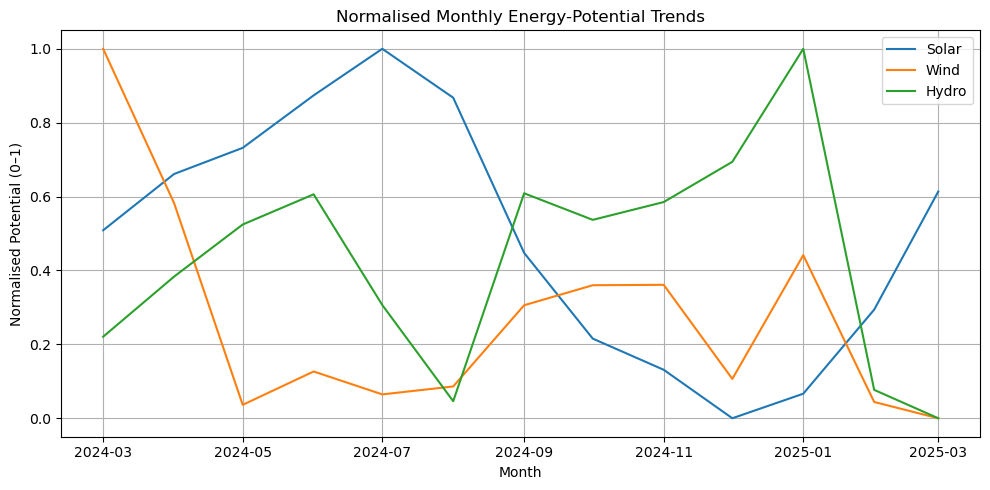

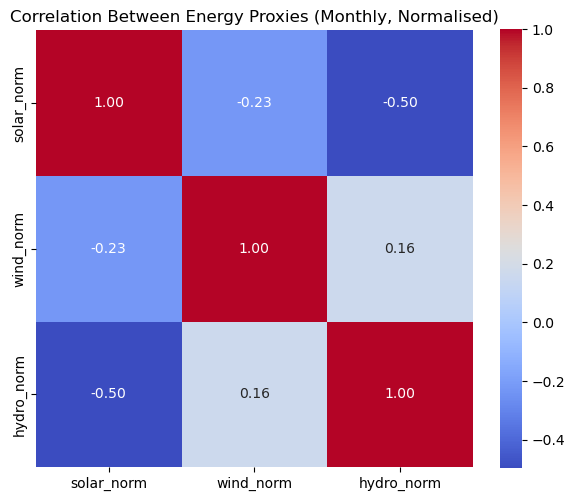

In [11]:
# 1) Build a month‐level DataFrame (one row per calendar month)
period = weather_data_df.index.to_period("M")
period.name = "month"  # name the PeriodIndex so reset_index() creates a "month" column

monthly_energy = (
    weather_data_df
    .groupby(period)
    .agg({
        "solar_potential_month_avg": "first",
        "wind_potential_month_avg":  "first",
        "hydro_potential_month_avg": "first",
    })
    .reset_index()  # now yields a DataFrame with a "month" column
)

# 2) Convert the Period to a timestamp for plotting
monthly_energy["date"] = monthly_energy["month"].dt.to_timestamp()

# 3) Normalise the monthly averages
scaler = MinMaxScaler()
normalised_monthly = scaler.fit_transform(monthly_energy[[
    "solar_potential_month_avg",
    "wind_potential_month_avg",
    "hydro_potential_month_avg",
]])
monthly_energy[["solar_norm", "wind_norm", "hydro_norm"]] = normalised_monthly

# 4) Plot normalised monthly trends
plt.figure(figsize=(10, 5))
plt.plot(monthly_energy["date"], monthly_energy["solar_norm"], label="Solar")
plt.plot(monthly_energy["date"], monthly_energy["wind_norm"],  label="Wind")
plt.plot(monthly_energy["date"], monthly_energy["hydro_norm"], label="Hydro")
plt.title("Normalised Monthly Energy-Potential Trends")
plt.xlabel("Month")
plt.ylabel("Normalised Potential (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Monthly correlation matrix
monthly_corr = monthly_energy[["solar_norm", "wind_norm", "hydro_norm"]].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(monthly_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Between Energy Proxies (Monthly, Normalised)")
plt.tight_layout()
plt.show()


### Seasonal contribution to annual potentials

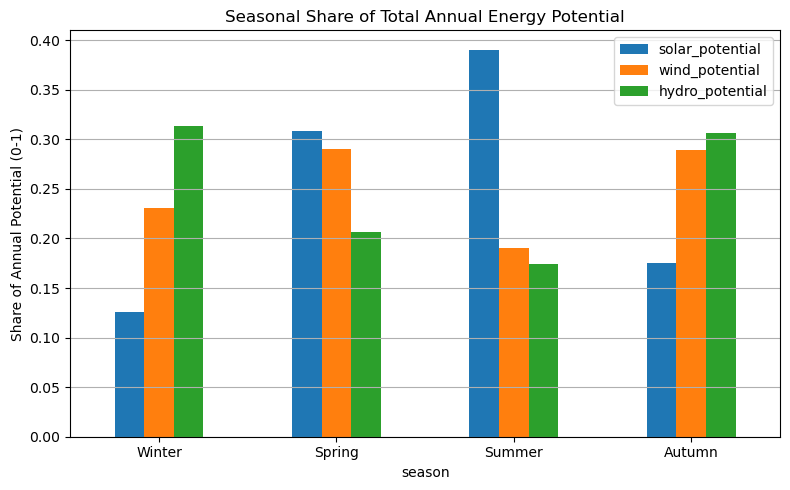

In [268]:
# Sum energy potential by season
seasonal_sum = weather_data_df.groupby('season')[
    ['solar_potential', 'wind_potential', 'hydro_potential']
].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Compute percentage contribution of each season to the annual total
seasonal_share = seasonal_sum.div(seasonal_sum.sum())

# Plot
seasonal_share.plot(kind='bar', figsize=(8, 5), rot=0)
plt.title("Seasonal Share of Total Annual Energy Potential")
plt.ylabel("Share of Annual Potential (0-1)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Streamlit Web App

In [12]:
weather_data_df.to_parquet("sion_weather_enriched.parquet")

def load_data():
    df = pd.read_parquet("sion_weather_enriched.parquet")
    df.index = pd.to_datetime(df.index) # convert time stamp index into datetime object to enable future time-based slicing in figures
    return df
weather_df = load_data()

print(weather_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-03-20 00:00:00 to 2025-03-20 23:00:00
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   temperature_2m                   8784 non-null   float64 
 1   relative_humidity_2m             8784 non-null   int64   
 2   rain                             8784 non-null   float64 
 3   snowfall                         8784 non-null   float64 
 4   precipitation                    8784 non-null   float64 
 5   cloudcover                       8784 non-null   int64   
 6   shortwave_radiation              8784 non-null   float64 
 7   windspeed_10m                    8784 non-null   float64 
 8   year                             8784 non-null   int32   
 9   month                            8784 non-null   int32   
 10  day                              8784 non-null   int32   
 11  hour                             